# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas
import holoviews as hv
%config InlineBackend.figure_format='retina'

# Load the data (don't forget to export a csv once its clean)

In [3]:
columns = ['State', 'Year', 'Product Name', 'Number of Prescriptions']
filenames = ['State_Drug_Utilization_Data_' + str(i) + '.csv' for i in range(1991, 2019)]

df = pd.concat(pd.read_csv(filename, usecols=columns)
               for filename in filenames)

In [7]:
df.shape

(82413509, 4)

In [11]:
df.head()

,State,Year,Product Name,Number of Prescriptions
0,MA,1991,Dicyclomin,29.0
1,AR,1991,NaN,NaN
2,CT,1991,GUAIFED-PD,124.0
3,TN,1991,LOMOTIL,NaN
4,TX,1991,DYMELOR 25,NaN


# Optimize memory usage

In [5]:
# Perform real memory usage calculation at the cost of computational resources

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82413509 entries, 0 to 2365964
Data columns (total 4 columns):
State                      object
Year                       int64
Product Name               object
Number of Prescriptions    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 11.5 GB


In [14]:
# Average memory usage by datatype

for dtype in ['float','int','object']:
    selected_dtype = df.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

Average memory usage for float columns: 628.77 MB
Average memory usage for int columns: 628.77 MB
Average memory usage for object columns: 3497.44 MB


In [23]:
# Function to optimize integer columns with subtypes

# use .select_dtypes to select integer columns
# downcast to the best integer subtype using .to_numeric()

def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

df_int = df.select_dtypes(include=['int'])
converted_int = df_int.apply(pd.to_numeric,downcast='unsigned')

print('Original:', mem_usage(df_int))
print('Converted:', mem_usage(converted_int))

compare_ints = pd.concat([df_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

Original: 1257.53 MB
Converted: 785.96 MB


,before,after
uint16,NaN,1.0
int64,1.0,NaN


The improvement in memory from downcasting is amazing already, let's keep doing it.

In [24]:
# Optimize float columns with the function

df_float = df.select_dtypes(include=['float'])
converted_float = df_float.apply(pd.to_numeric,downcast='float')

print(mem_usage(df_float))
print(mem_usage(converted_float))

compare_floats = pd.concat([df_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

1257.53 MB
943.15 MB


,before,after
float32,NaN,1.0
float64,1.0,NaN


Converting object to category type typically saves huge amounts of memory, for this to work propery, the data should have have cardinality of no more than 50%.

In [33]:
# Let's reload the dataset with the best possible dtypes

# State and Product Name are our object columns
# unique values in those columns definitely comprise < 50% of the data
# float32 for number of prescriptions
# uint16 for year 
# category for state and product name

columns = ['State', 'Year', 'Product Name', 'Number of Prescriptions']
filenames = ['State_Drug_Utilization_Data_' + str(i) + '.csv' for i in range(1991, 2019)]

df = pd.concat(pd.read_csv(filename, usecols=columns, 
               dtype={'Year':'uint16','Number of Prescriptions':'float32'})
               for filename in filenames)

# For some reason category conversion doesn't work from read_csv
# so we'll do it separate 

df[['State', 'Product Name']] = df[['State', 'Product Name']].astype('category')

In [11]:
# Check memory usage now

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82413509 entries, 0 to 2365964
Data columns (total 4 columns):
State                      category
Year                       uint16
Product Name               category
Number of Prescriptions    float32
dtypes: category(2), float32(1), uint16(1)
memory usage: 1.5 GB


**The amount of memory saved by converting to category is insane.**

# Clean the data

In [15]:
df.isna().sum()

State                             0
Year                              0
Product Name                 379049
Number of Prescriptions    41161540
dtype: int64

In [47]:
len(df[df['Product Name'] == '?'])

6938

In [49]:
(df.loc[(df['Year'] == 2007) & (df['State'] == 'SD'), 'Number of Prescriptions']).isna().sum()

12132

In [50]:
# Replace ? with nan

df = df.replace('?', np.NaN)

# Drop the nans

df = df.dropna(subset=['Product Name'])

# Remove aggregated XX entries

df = df[df.State != 'XX']

# Nullify and impute SD Precriptions in 2007

df.loc[(df['Year'] == 2007) & (df['State'] == 'SD'), 'Number of Prescriptions'] = np.nan

# Randomly sample values from comparable North Dakota
# to fill Nans in South Dakota 2007

samp = df.loc[(df['Year'] <= 2008) & (df['State'] == 'ND'), 'Number of Prescriptions'].sample(12132)
df.loc[(df['Year'] == 2007) & (df['State'] == 'SD'), 'Number of Prescriptions'] = samp.values

In [51]:
# Check missing values

df.isna().sum()

State                             0
Year                              0
Product Name                      0
Number of Prescriptions    39634733
dtype: int64

In [31]:
# Export the cleaned version so I don't have to load the whole thing everytime

df.to_csv('Medicaid_data_1991_2017.csv')

In [52]:
# Pearson correlation for all entries including non-numeric

df.apply(lambda x: x.factorize()[0]).corr()

,State,Year,Product Name,Number of Prescriptions
State,1.000000,0.012710,-0.002349,-0.041835
Year,0.012710,1.000000,0.474652,0.010433
Product Name,-0.002349,0.474652,1.000000,0.004970
Number of Prescriptions,-0.041835,0.010433,0.004970,1.000000


# Stacked Barchart of # prescriptions

In [34]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77020970 entries, 0 to 77020969
Data columns (total 5 columns):
Unnamed: 0                 int64
State                      category
Year                       int64
Product Name               category
Number of Prescriptions    float64
dtypes: category(2), float64(1), int64(2)
memory usage: 2.1 GB


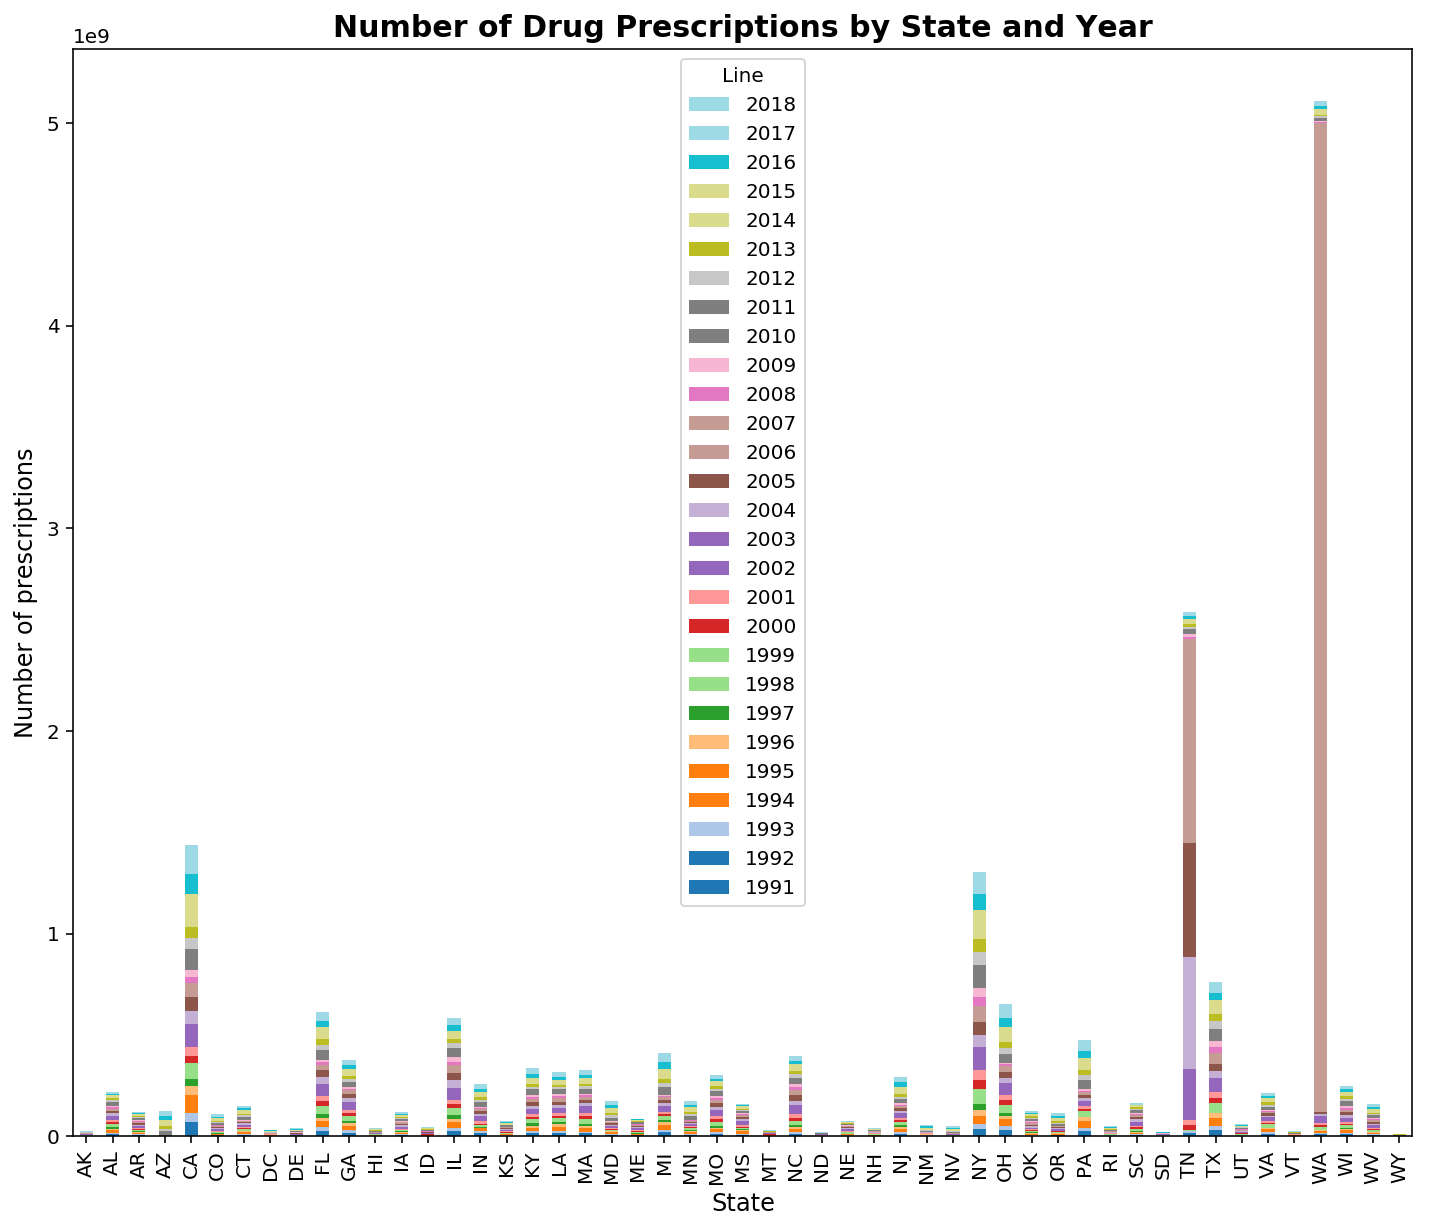

In [6]:
pv = df.pivot_table(values='Number of Prescriptions', index='State', columns='Year', aggfunc=np.sum)

# Number of prescriptions by state 2007 - 2017

ax = pv.sort_values('State').plot.bar(stacked=True, figsize=(12,10), cmap='tab20')
ax.set_title('Number of Drug Prescriptions by State and Year', size=15, weight='bold')
plt.ylabel('Number of prescriptions', size=12)
plt.xlabel('State', size=12)

# Reverse the legend labels and handles for better readability

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), title='Line', loc='best');

In [143]:
df.shape

(77020970, 4)

In [8]:
len(df.loc[df['Number of Prescriptions'] > 20000, 'Number of Prescriptions'])

46512

In [10]:
# Nan the rows where Number of prescriptions > 20000

df.loc[df['Number of Prescriptions'] > 20000, 'Number of Prescriptions'] = np.nan

In [35]:
df.isna().sum()

Unnamed: 0                        0
State                             0
Year                              0
Product Name                      0
Number of Prescriptions    39681245
dtype: int64

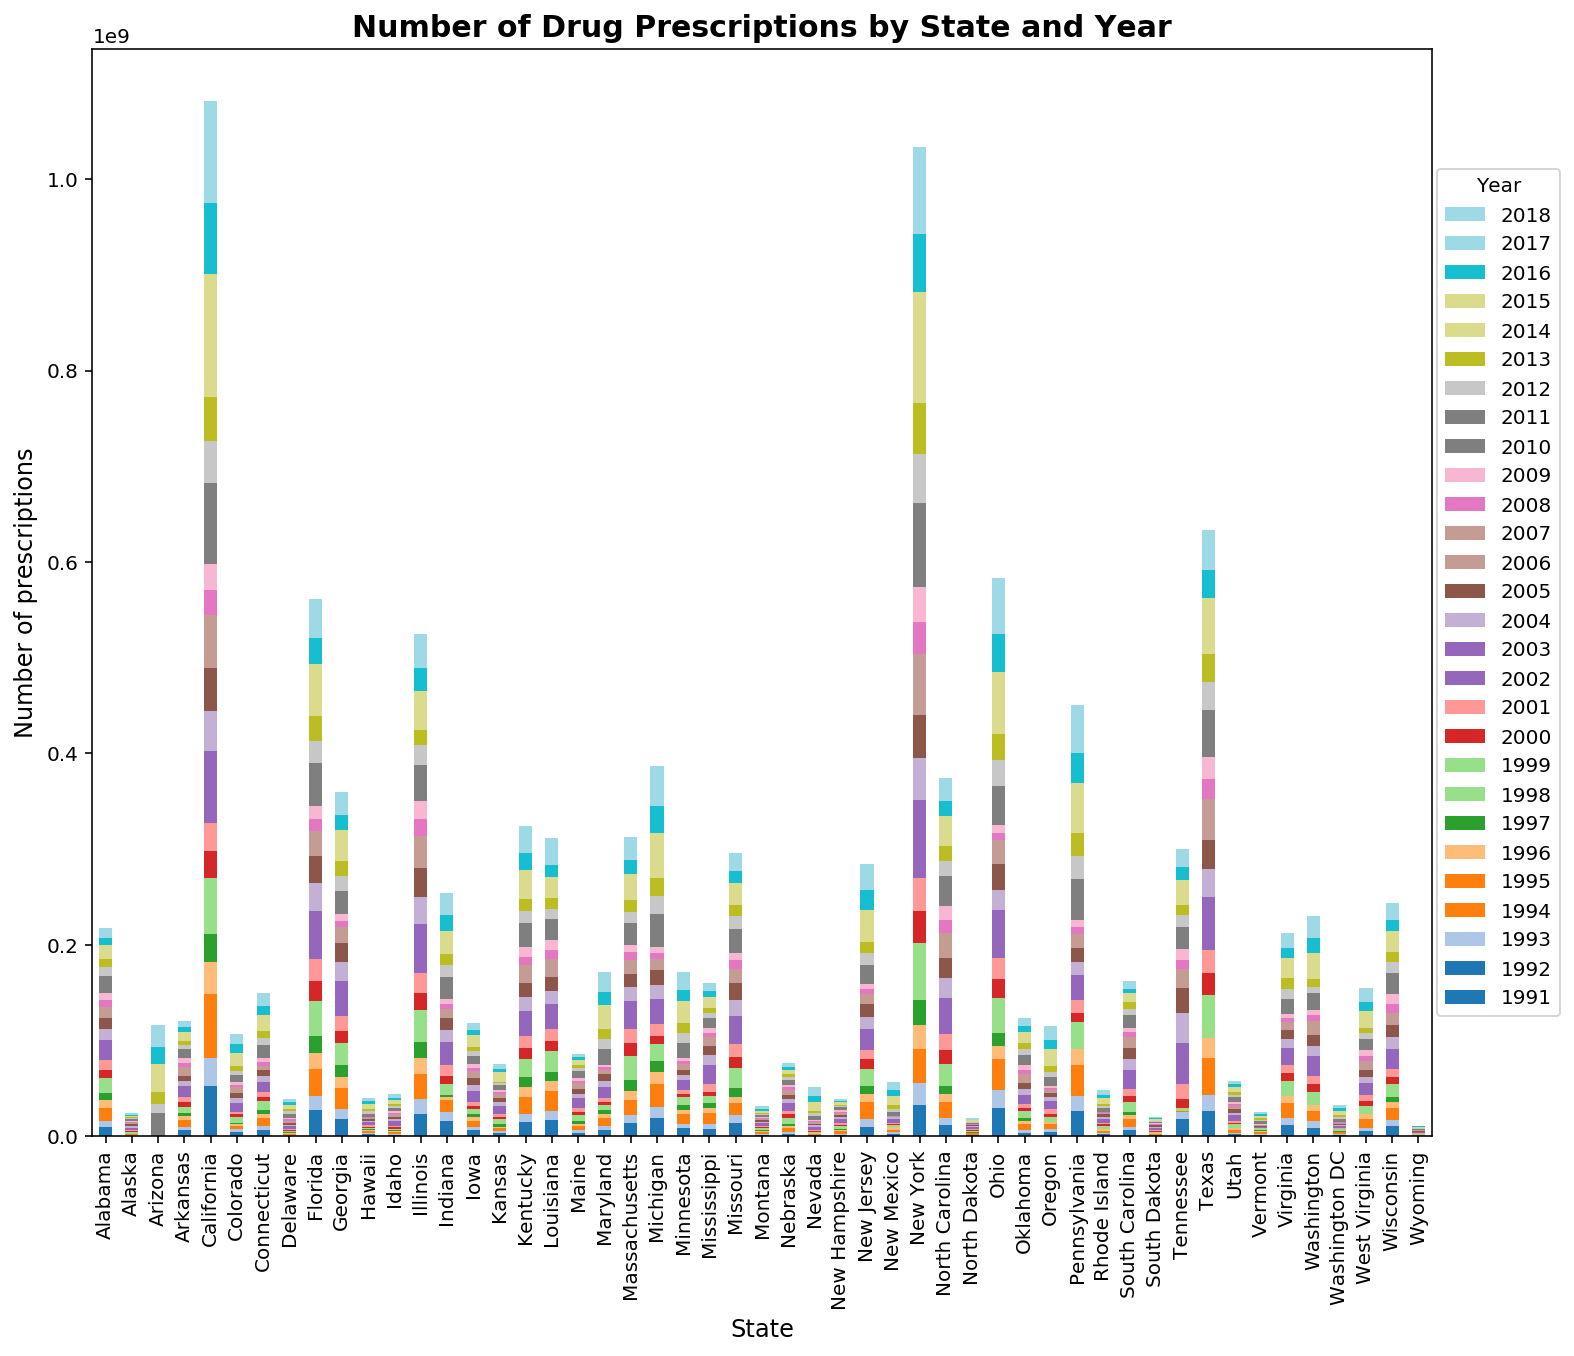

In [69]:
## Again without the outliers
pv = df.pivot_table(values='Number of Prescriptions', index='State', columns='Year', aggfunc=np.sum)

# Number of prescriptions by state 2007 - 2017

ax = pv.sort_values('State').plot.bar(stacked=True, figsize=(12,10), cmap='tab20')
ax.set_title('Number of Drug Prescriptions by State and Year', size=15, weight='bold')
plt.ylabel('Number of prescriptions', size=12)
plt.xlabel('State', size=12)

# Reverse the legend labels and handles for better readability

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), title='Year', loc='center', bbox_to_anchor=(1.05, 0.5));

Populations:

* Texas 28.3 million
* Florida 21 million
* Illinois 12.8 million
* Ohio 11.6 million



# Heatmap visulization

In [5]:
# Make abbreviated state into full

abb = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'Washington DC': 'DC',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

abb = {state: abbrev for abbrev, state in abb.items()}
df['State'] = df['State'].map(abb)

In [23]:
# Get the top 100 most prescribed drugs in the nation
# 109 because we drop some of the ones with missing entries

top100 = df.groupby('Product Name')['Number of Prescriptions'].agg('sum').sort_values(ascending=False).head(110)

# get names of drugs into a variable

t100 = top100.index.values
top100.head(20)

Product Name
AMOXICILLI    183065236.0
HYDROCODON    181849772.0
FUROSEMIDE    136410084.0
LISINOPRIL    124023503.0
IBUPROFEN     112827544.0
ALBUTEROL     107983846.0
ALPRAZOLAM     98833121.0
ACETAMINOP     88328731.0
CLONAZEPAM     87034573.0
LORAZEPAM      84798196.0
LEVOTHYROX     79622386.0
CEPHALEXIN     75569261.0
METOPROLOL     75377534.0
TRAZODONE      73869296.0
AZITHROMYC     72270736.0
RANITIDINE     71781947.0
METFORMIN      71067160.0
GABAPENTIN     70525003.0
PREDNISONE     68403692.0
PROMETHAZI     66694297.0
Name: Number of Prescriptions, dtype: float64

In [24]:
# Make new df of top 100 drugs

df100 = pd.concat(df.loc[df['Product Name'] == drug] for drug in t100)
# df100 = df100.sort_values('State')
df100.head()

,State,Year,Product Name,Number of Prescriptions
49,Virginia,1991,AMOXICILLI,24.0
475,Minnesota,1991,AMOXICILLI,33.0
539,Iowa,1991,AMOXICILLI,77.0
811,Idaho,1991,AMOXICILLI,NaN
912,Kansas,1991,AMOXICILLI,NaN


In [43]:
# Make Total Number of Prescriptions for easy plotting

df100['Total Number of Prescriptions'] = df100.groupby(['Product Name', 'State'])['Number of Prescriptions'].transform(sum)
df100 = df100.sort_values('State')

# Prescription Rates of Top 100 Drugs 1991 - 2018

In [64]:
df100.head()

,State,Year,Product Name,Number of Prescriptions,Total Number of Prescriptions
7550160,Alabama,1994,NIFEDIPINE,NaN,364461.0
65379965,Alabama,2015,LISINOPRIL,27.0,1338742.0
26788960,Alabama,2002,CEPHALEXIN,456.0,1748846.0
36337853,Alabama,2006,TEMAZEPAM,NaN,245947.0
33885534,Alabama,2005,CARISOPROD,426.0,397459.0


In [55]:
# imports for visualization

import hvplot.pandas
import holoviews as hv

In [68]:
# Heatmap by state and year

heatmap = df100.hvplot.heatmap('Product Name', 'State', 'Total Number of Prescriptions',
          height=500, width=1000, xaxis=None, hover_cols=['Year'], flip_yaxis=True,
          title='Top 100 Most Prescribed Drugs in the Nation in 1991 - 2018', cmap='fire')
heatmap

:HeatMap   [Product Name,State]   (Total Number of Prescriptions,Year)

# See prescriptions by state

In [73]:
# Get rid of 2018 since there's only data for 1/2 the year

no2018_df = df[df['Year'] != 2018]

p_agg = no2018_df.groupby(['Year', 'State'])['Number of Prescriptions'].sum()
by_state = p_agg.hvplot('Year', groupby='State', width=500, dynamic=False)
by_state

by_state = macro.to(hv.Curve, 'year', 'unem', groupby='country')
print(curves)
curves

:HoloMap   [State]
   :Curve   [Year]   (Number of Prescriptions)

# Get prescriptions per number of medicaid patients

In [ ]:
numdict = {    
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'Washington DC': 'DC',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}